# MODELS

## ARIMA

Auto Regressive Integrated Moving Average

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
df = pd.read_csv('/kaggle/input/time-series-datasets/monthly-beer-production-in-austr.csv')
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)
df = df.set_index(['Month'])
df.head(5)

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


### FUNCTIONALITIES TO ADD TO CLASS
        1. Train model/parameter tuning
        2. Forecasting
        3. Visualizations: Autocorrelation, Partial Autocorrelation, ETS Decomp


### Visualizations

In [3]:
df.index.name

'Month'

In [4]:
def plot_series(df: pd.DataFrame):
    plt.xlabel(df.index.name)
    plt.ylabel(df.columns[0])
    plt.plot(df)
    plt.title('Series plot')

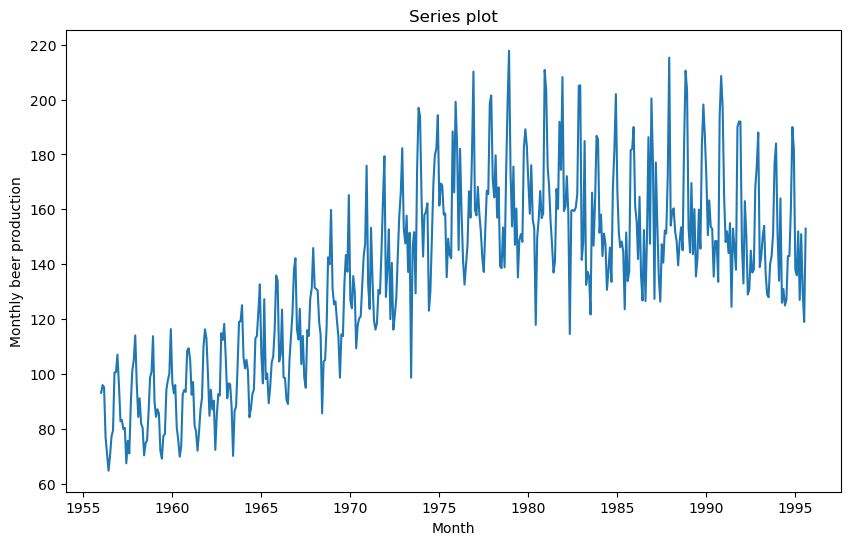

In [5]:
plot_series(df)

In [6]:
def plot_rolling_stats(df: pd.DataFrame, window: int):
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()
    orig = plt.plot(df, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

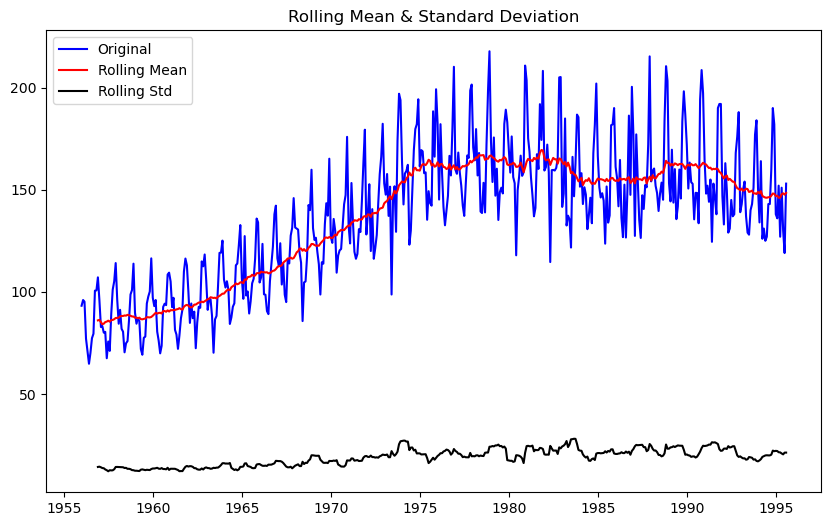

In [7]:
plot_rolling_stats(df, 12)

In [8]:
def test_stationarity(df: pd.DataFrame, col: str):
    # Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(df[col], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [9]:
test_stationarity(df, 'Monthly beer production')

Results of Dickey Fuller Test:
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [10]:
def acf_differencing_plots(df, max_order):
    fig, axes = plt.subplots(max_order+1, 3)
    axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
    plot_acf(df, ax=axes[0, 1])
    plot_pacf(df, ax=axes[0, 2])
    
    
    for order in range(1, max_order+1):
        axes[order, 0].plot(df.diff(order)); axes[order, 0].set_title(str(order)+' Order Differencing')
        plot_acf(df.diff(order).dropna(), ax=axes[order, 1])
        plot_pacf(df.diff(order).dropna(), ax=axes[order, 2])
        
    plt.tight_layout()
        

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


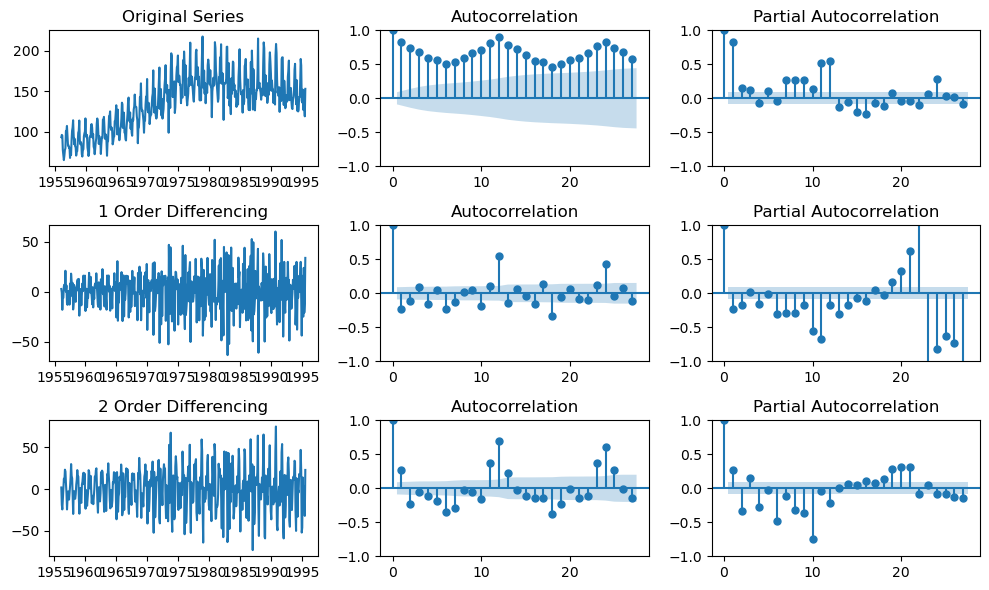

In [11]:
acf_differencing_plots(df, 2)

In [12]:
def ets_decomposition_plot(timeseries: pd.Series, plot = 'all'):
    if plot == 'all':
        seasonal_decompose(timeseries, model = 'multiplicative').plot()
    elif plot == 'seasonal':
        seasonal_decompose(timeseries, model = 'multiplicative').seasonal.plot()
    elif plot == 'error':
        seasonal_decompose(timeseries, model = 'multiplicative').resid.plot()
    elif plot == 'trend':
        seasonal_decompose(timeseries, model = 'multiplicative').trend.plot()
    else:
        print('Incorrect value \''+ plot + '\' for \'plot\'')
        
    

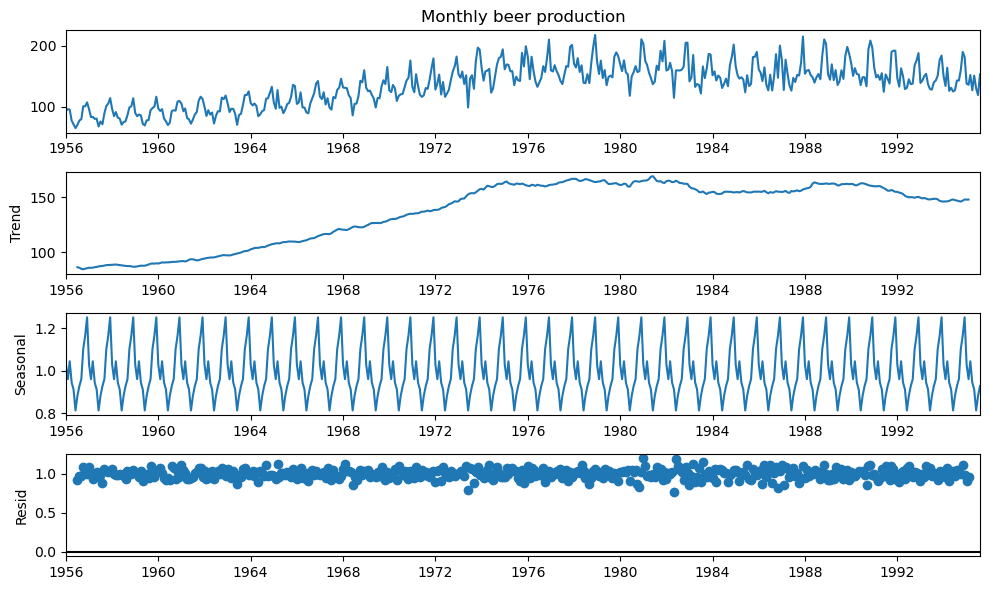

In [13]:
ets_decomposition_plot(df['Monthly beer production'])

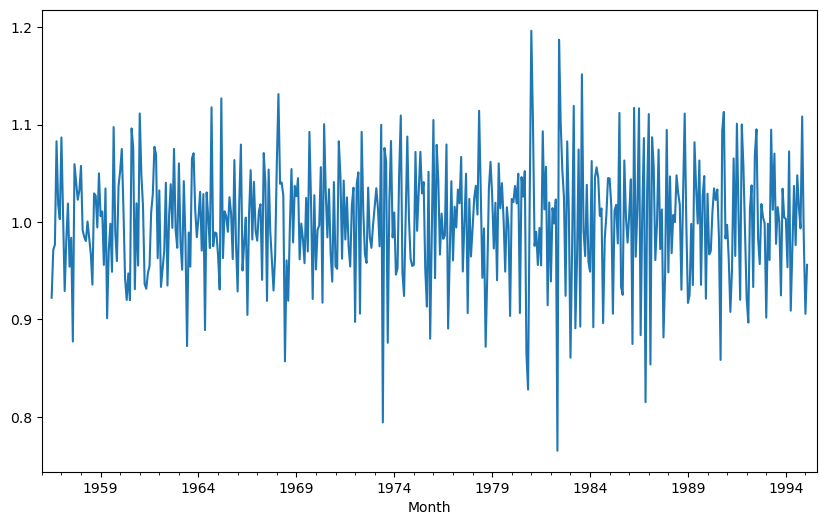

In [14]:
ets_decomposition_plot(df['Monthly beer production'],'error')

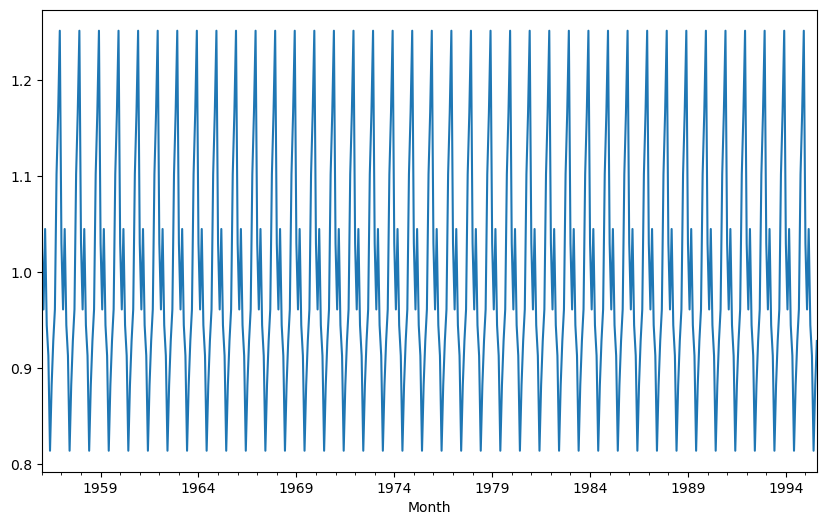

In [15]:
ets_decomposition_plot(df['Monthly beer production'],'seasonal')

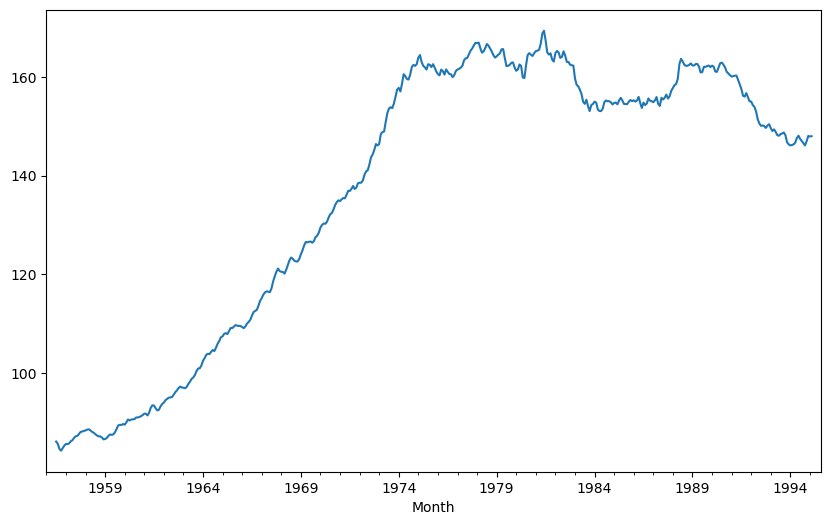

In [16]:
ets_decomposition_plot(df['Monthly beer production'],'trend')